## Задание
1. Считать изображение МРТ ("mri.tif")
2. Пространственная фильтрация:
   - Добавить на изображение импульсный шум и применить медианную фильтрацию
   - Отдельно выделить границы, рассчитав модуль градиента (как `np.sqrt(sobel_x**2 + sobel_y**2)`)
3. Частотная фильтрация:
   - Построить частотный спектр изображения
   - Отдельно добавить на исходное изображение гауссов шум и определить наиболее эффективный ФНЧ в частотной области, используя в качестве критерия показатель PSNR

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util, filters, color
from scipy import ndimage
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
image = cv2.cvtColor(cv2.imread('filtration/mri.tif'), cv2.COLOR_BGR2GRAY)
image.shape

(512, 512)

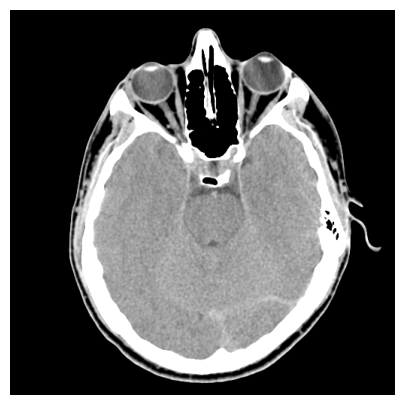

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

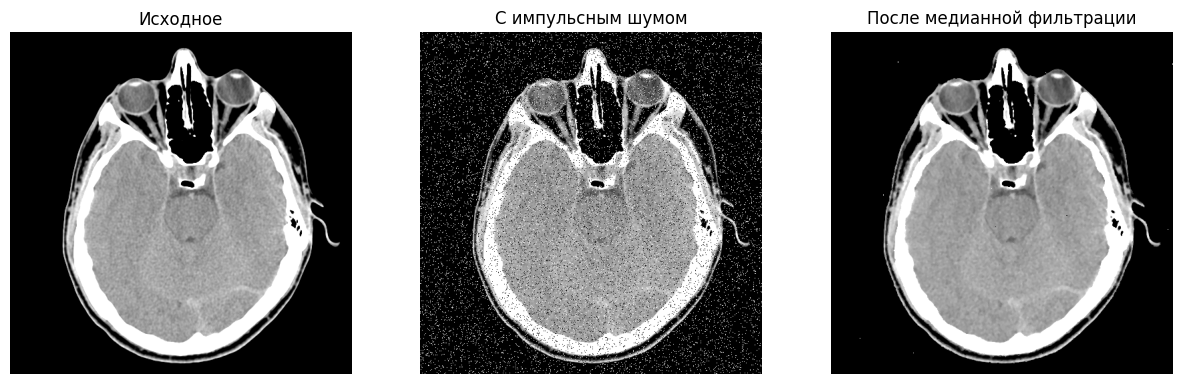

In [4]:
noisy_sp = util.random_noise(image, mode='s&p', amount=0.1)
median_filtered = filters.median(noisy_sp, np.ones((3,3)))

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Исходное")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("С импульсным шумом")
plt.imshow(noisy_sp, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("После медианной фильтрации")
plt.imshow(median_filtered, cmap='gray')
plt.axis('off')

plt.show()

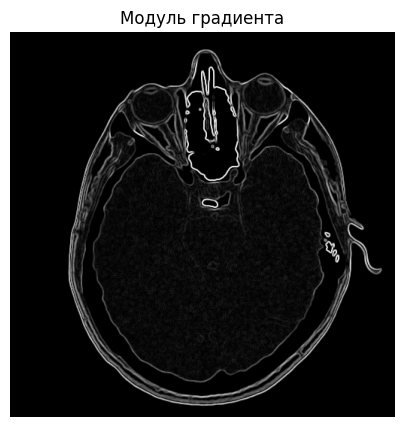

In [5]:
sobel_x = filters.sobel_h(image)
sobel_y = filters.sobel_v(image)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

plt.figure(figsize=(5,5))
plt.title("Модуль градиента")
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')
plt.show()

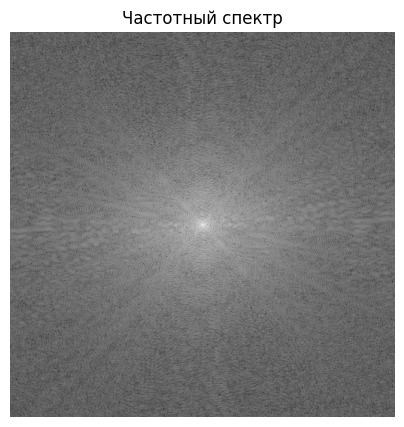

In [6]:
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log1p(np.abs(fshift))

plt.figure(figsize=(5,5))
plt.title("Частотный спектр")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
image_norm = image.astype(np.float64) / 255.0
noisy_gauss = util.random_noise(image_norm, mode='gaussian', var=0.1)

def low_pass_filter(img, radius):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros_like(img)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (y - crow)**2 + (x - ccol)**2 <= radius**2
    mask[mask_area] = 1
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.fft.ifft2(f_ishift)
    return np.abs(img_filtered)

Радиус 5: PSNR = 13.510
Радиус 10: PSNR = 15.161
Радиус 15: PSNR = 15.877
Радиус 20: PSNR = 16.245
Радиус 25: PSNR = 16.556
Радиус 30: PSNR = 16.882
Радиус 35: PSNR = 17.201
Радиус 40: PSNR = 17.454
Радиус 45: PSNR = 17.658
Радиус 50: PSNR = 17.805
Радиус 55: PSNR = 17.896
Радиус 60: PSNR = 17.944
Радиус 65: PSNR = 17.961
Радиус 70: PSNR = 17.956
Радиус 75: PSNR = 17.935
Радиус 80: PSNR = 17.900
Радиус 85: PSNR = 17.854
Радиус 90: PSNR = 17.789
Радиус 95: PSNR = 17.707
Наиболее эффективный радиус ФНЧ: 65, PSNR = 17.961


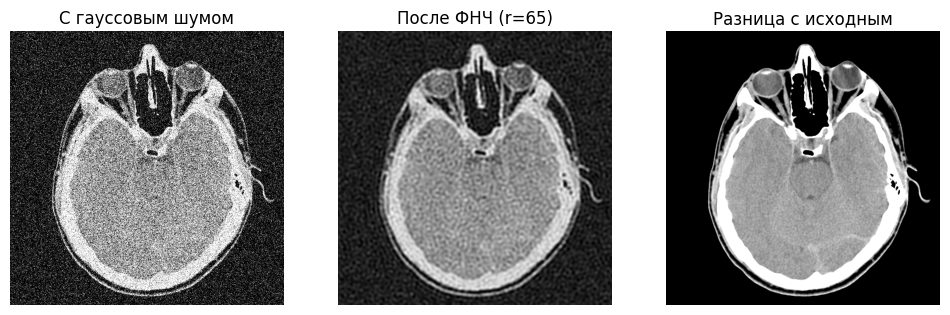

In [8]:
radii = np.arange(5, 100, 5)
best_psnr = 0
best_radius = 0
for r in radii:
    filtered = low_pass_filter(noisy_gauss, r)
    current_psnr = psnr(image_norm, filtered)
    print(f"Радиус {r}: PSNR = {current_psnr:.3f}")
    if current_psnr > best_psnr:
        best_psnr = current_psnr
        best_radius = r

best_filtered = low_pass_filter(noisy_gauss, best_radius)
print(f"Наиболее эффективный радиус ФНЧ: {best_radius}, PSNR = {best_psnr:.3f}")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("С гауссовым шумом")
plt.imshow(noisy_gauss, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title(f"После ФНЧ (r={best_radius})")
plt.imshow(best_filtered, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Разница с исходным")
plt.imshow(np.abs(image - best_filtered), cmap='gray')
plt.axis('off')
plt.show()